# 04 Gaze Similarity vs. Memorability Bins

For each metric, we bin videos by true memorability, then plot mean±SEM of metric scores per bin.

In [18]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import sem
from pathlib import Path

In [56]:
# --- Configuration ---
dataset = 'videomem'  # or 'videomem'

if dataset == "memento":
    NUM_FRAMES = 5
else: 
    NUM_FRAMES = 7

paths = {
    'memento': {
        'all_dict': './pickles/model_human_metrics/FINAL_memento_metrics_gaussianBeforeRescale.pkl',
        'aucp_dict': './pickles/model_human_metrics/FINAL_memento_percentiles_all.pkl',
        'mem_csv': './pickles/model_predictions/memento.csv',
        'name2id': './pickles/model_predictions/name2id.pkl'
    },
    'videomem': {
        'all_dict': './pickles/model_human_metrics/FINAL_videomem_metrics_gaussianBeforeRescale.pkl',
        'aucp_dict': './pickles/model_human_metrics/FINAL_videomem_percentiles_all.pkl',
        'mem_csv': './pickles/model_predictions/videomem.csv'
    }
}[dataset]

ALL_SPLIT_PATH = './pickles/model_human_metrics/eyetracking_split_all_'+dataset+'_frames.pkl'
SHUFFLED_SPLIT_PATH = './pickles/model_human_metrics/eyetracking_split_shuffled_'+dataset+'_frames.pkl'
NONCENTER_SPLIT_PATH = './pickles/model_human_metrics/eyetracking_split_nonCenter35_'+dataset+'_frames.pkl'
NONCENTER_SHUFFLED_SPLIT_PATH = './pickles/model_human_metrics/eyetracking_split_shuffled_nonCeter35_'+dataset+'_frames.pkl'

### Load Data

In [20]:
with open(paths['all_dict'], 'rb') as f:
    all_dict = pickle.load(f)
with open(paths['aucp_dict'], 'rb') as f:
    aucp = pickle.load(f)

In [21]:
all_dict['AUC_P'] = aucp

In [22]:
len(all_dict['AUC_P'])

139

In [23]:
# Load true memorability scores
df_mem = pd.read_csv(paths['mem_csv'])

In [24]:
with open(paths['name2id'], 'rb') as f:
        name2id = pickle.load(f)

In [25]:
id2name = {v: k for k, v in name2id.items()}

In [26]:
if dataset == 'memento':
    
    # Convert video filenames in all_dict to numeric IDs
    converted_dict = {}
    for metric, vid_scores in all_dict.items():
        new_scores = {}
        for fname, score in vid_scores.items():
            vid_id = id2name.get(fname)
            if vid_id is not None:
                new_scores[vid_id] = score
        converted_dict[metric] = new_scores
    all_dict = converted_dict
    # Use 'true' column for memorability
    mem_series = df_mem.set_index('video_id')['true']
else:
    # videomem uses integer video IDs directly
    mem_series = df_mem.set_index('video_id')['true']

In [27]:
common_vids = sorted(set(mem_series.index) & set(all_dict[next(iter(all_dict))].keys()))
mem_series = mem_series.loc[common_vids]

### Bin memorability into equal-sized bins by count

In [28]:
n_bins = 4
# use quantile-based binning to have roughly equal videos per bin
df_bins = pd.qcut(mem_series, q=n_bins, labels=False, duplicates='drop')
# map integer bins to string labels of range
edges = sorted(mem_series.quantile(np.linspace(0,1,n_bins+1)))
labels = [f"({edges[i]:.2f}-{edges[i+1]:.2f})" for i in range(len(edges)-1)]
# assign bin labels
mem_bins = pd.Series(pd.cut(mem_series, bins=edges, labels=labels, include_lowest=True), index=mem_series.index)
# count videos per bin
bin_counts = mem_bins.value_counts().reindex(labels)

In [29]:
bin_counts

(0.42-0.74)    35
(0.74-0.81)    35
(0.81-0.88)    34
(0.88-0.99)    35
Name: true, dtype: int64

In [30]:
rows = []
for metric, vid_scores in all_dict.items():
    for vid, val in vid_scores.items():
        if vid in mem_bins.index:
            rows.append({'metric': metric,
                         'video_id': vid,
                         'score': val,
                         'bin': mem_bins.loc[vid]})

df_long = pd.DataFrame(rows)



#### Compute mean & SEM per bin

In [31]:
agg = df_long.groupby(['metric','bin'])['score'] \
             .agg(mean='mean', sem=lambda x: sem(x, nan_policy='omit')) \
             .reset_index()

### Plotting per metric

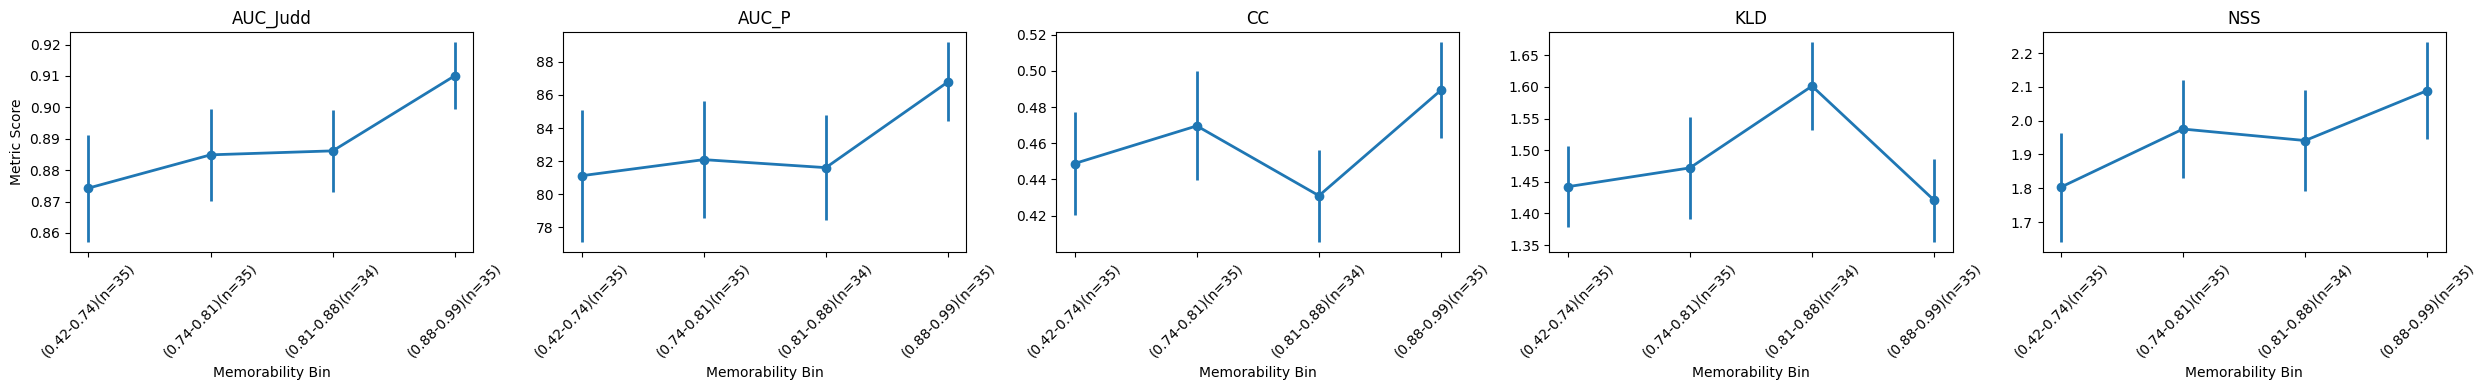

In [33]:
metrics_list = agg['metric'].unique()
fig, axes = plt.subplots(1, len(metrics_list), figsize=(5*len(metrics_list),4), sharey=False)
for ax, met in zip(axes, metrics_list):
    sub = agg[agg['metric']==met]
    ax.errorbar(sub['bin'], sub['mean'], yerr=sub['sem'], marker='o', linewidth=2)
    ax.set_title(met)
    # annotate bin counts in x-tick labels
    xticks = sub['bin'].tolist()
    xticklabels = [f"{b}(n={bin_counts[b]})" for b in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=45)
    ax.set_xlabel('Memorability Bin')
    if ax is axes[0]:
        ax.set_ylabel('Metric Score')

plt.tight_layout()
plt.show()

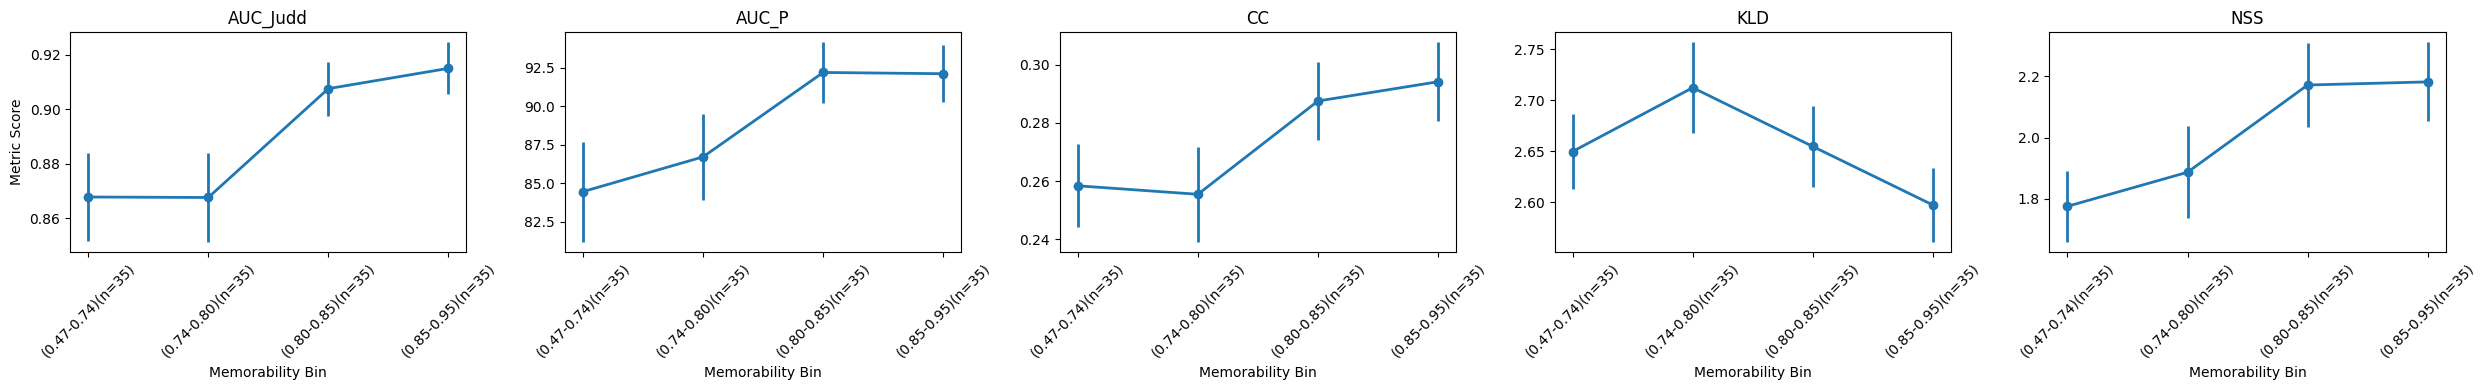

In [17]:
# videomem

### Additional Frame-wise Split Analysis

In [57]:
# Load split metrics
with open(ALL_SPLIT_PATH, 'rb') as f:
    center_all_frame_metrics = pickle.load(f)
with open(SHUFFLED_SPLIT_PATH, 'rb') as f:
    center_shuffled_frame_metrics = pickle.load(f)
with open(NONCENTER_SPLIT_PATH, 'rb') as f:
    all_frame_metrics = pickle.load(f)
with open(NONCENTER_SHUFFLED_SPLIT_PATH, 'rb') as f:
    shuffled_frame_metrics = pickle.load(f)

In [58]:
# Initialize containers
def init_frame_dict():
    return {frame: {'AUC_Judd': [], 'NSS': [], 'CC': [], 'KLD': []} for frame in range(NUM_FRAMES)}

In [59]:
all_means = init_frame_dict()
all_shuffled_means = init_frame_dict()
noncenter_means = init_frame_dict()
noncenter_shuffled_means = init_frame_dict()


In [60]:
# Collect means per frame
for entry in center_all_frame_metrics:
    for frame in range(NUM_FRAMES):
        for metric, values in entry.items():
            all_means[frame][metric].append(values[frame]['mean'])
for entry in center_shuffled_frame_metrics:
    for frame in range(NUM_FRAMES):
        for metric, values in entry.items():
            all_shuffled_means[frame][metric].append(values[frame]['mean'])
for entry in all_frame_metrics:
    for frame in range(NUM_FRAMES):
        for metric, values in entry.items():
            noncenter_means[frame][metric].append(values[frame]['mean'])
for entry in shuffled_frame_metrics:
    for frame in range(NUM_FRAMES):
        for metric, values in entry.items():
            noncenter_shuffled_means[frame][metric].append(values[frame]['mean'])

In [61]:
# Plot function
def plot_frame_metrics(all_means, all_shuffled_means, noncenter_means, dataset_name):
    frames = list(all_means.keys())
    metrics = ['AUC_Judd', 'NSS', 'CC', 'KLD']
    for metric in metrics:
        plt.figure(figsize=(10,6), dpi=150)
        plt.rcParams.update({'font.size': 7})
        plt.rcParams['axes.spines.right'] = False
        plt.rcParams['axes.spines.top'] = False

        vals_center = [np.mean(all_means[f][metric]) for f in frames]
        vals_center_shuf = [np.mean(all_shuffled_means[f][metric]) for f in frames]
        vals_noncenter = [np.mean(noncenter_means[f][metric]) for f in frames]

        plt.plot(frames, vals_center, label='Center H-H Mean', marker='o')
        plt.plot(frames, vals_center_shuf, label='Center H-H Shuffled', marker='s')
        plt.plot(frames, vals_noncenter, label='Off-Center H-H Mean', marker='^')

        title = metric.replace('AUC_Judd','AUC-J') if metric=='AUC_Judd' else metric
        plt.title(f'{title} over Frames ({dataset_name.title()})')
        plt.xlabel('Frame Index')
        plt.ylabel('Mean Score')
        plt.xticks(frames)
        plt.legend(ncol=3)
        plt.tight_layout()
        plt.show()


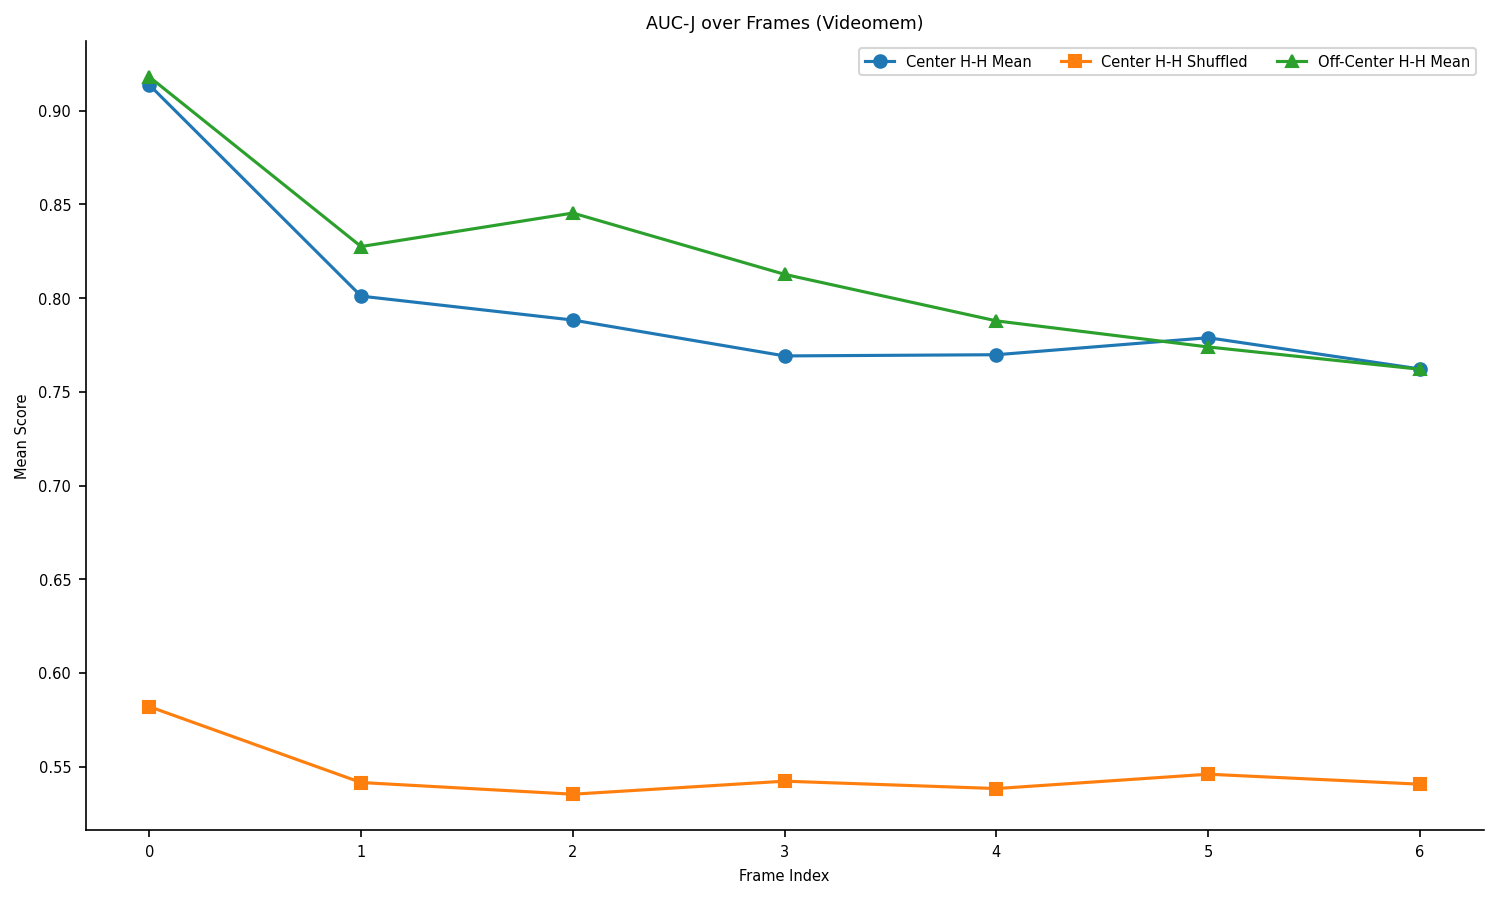

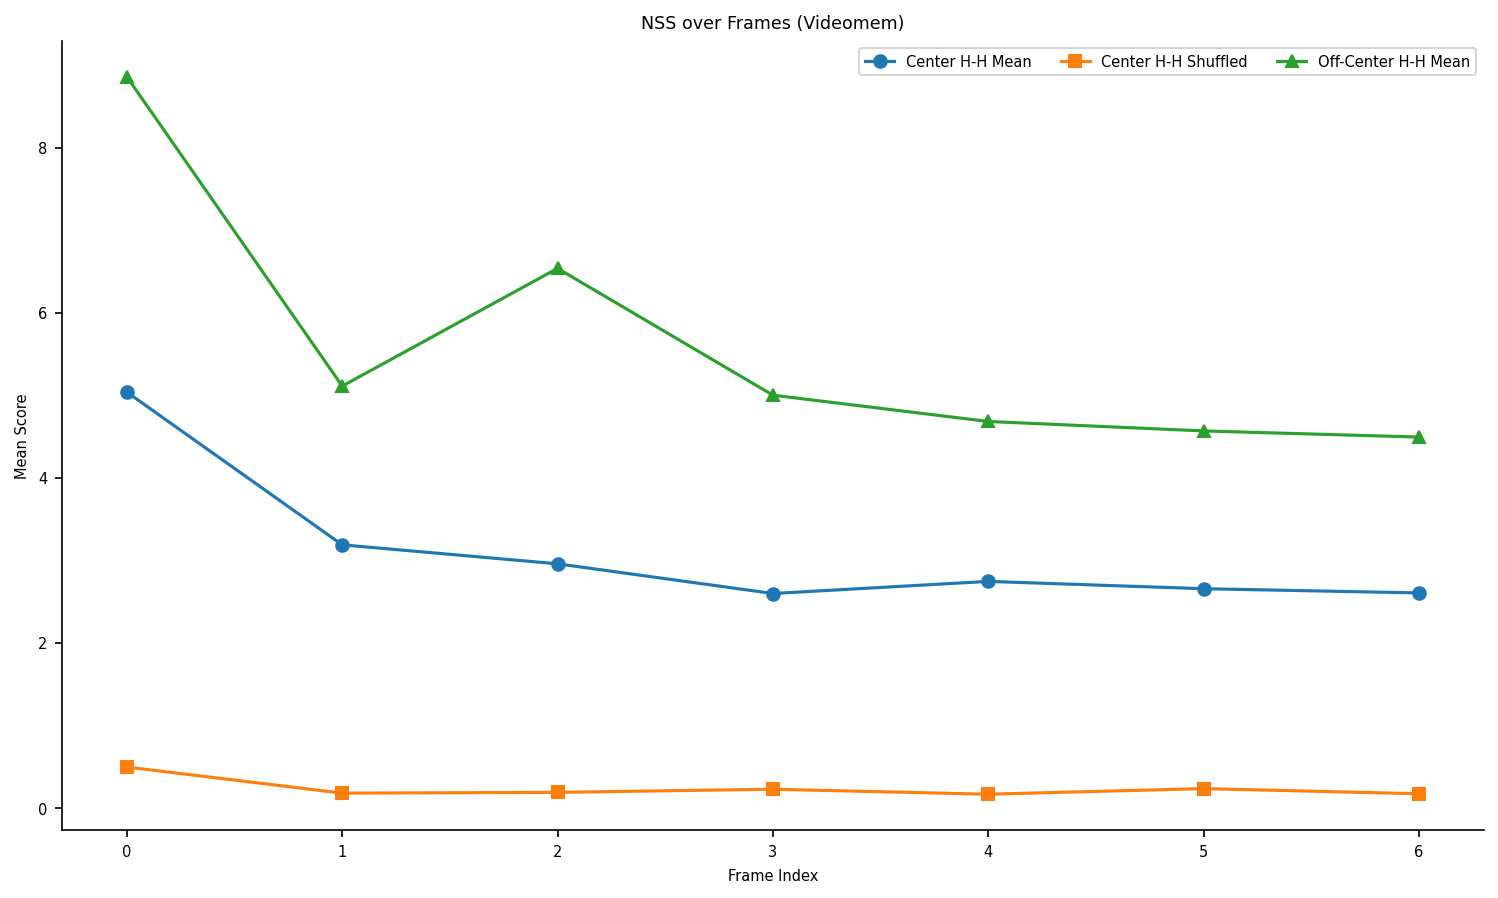

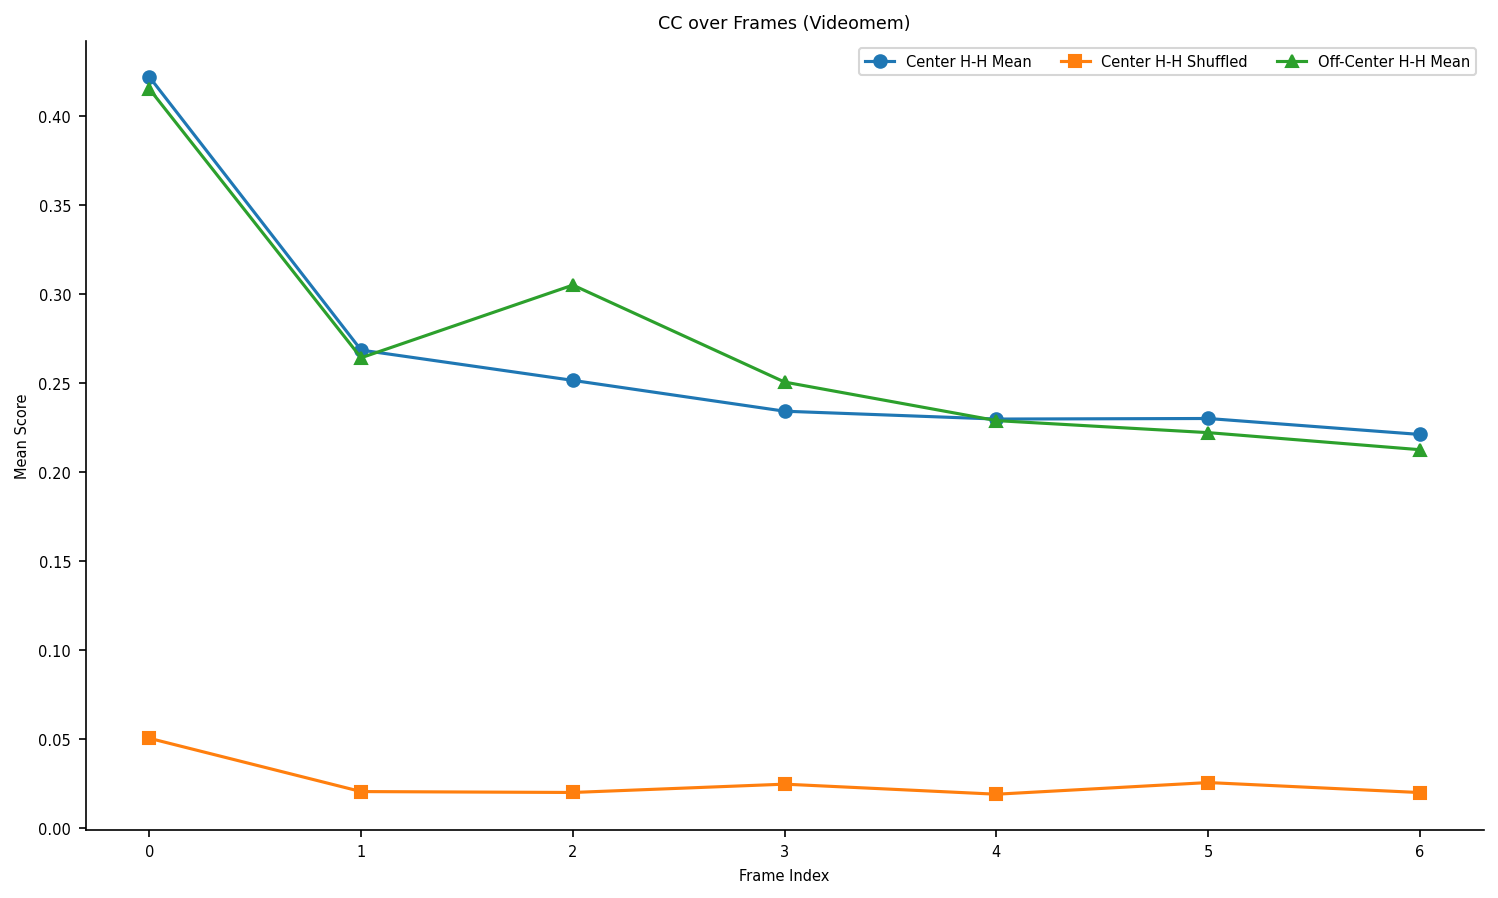

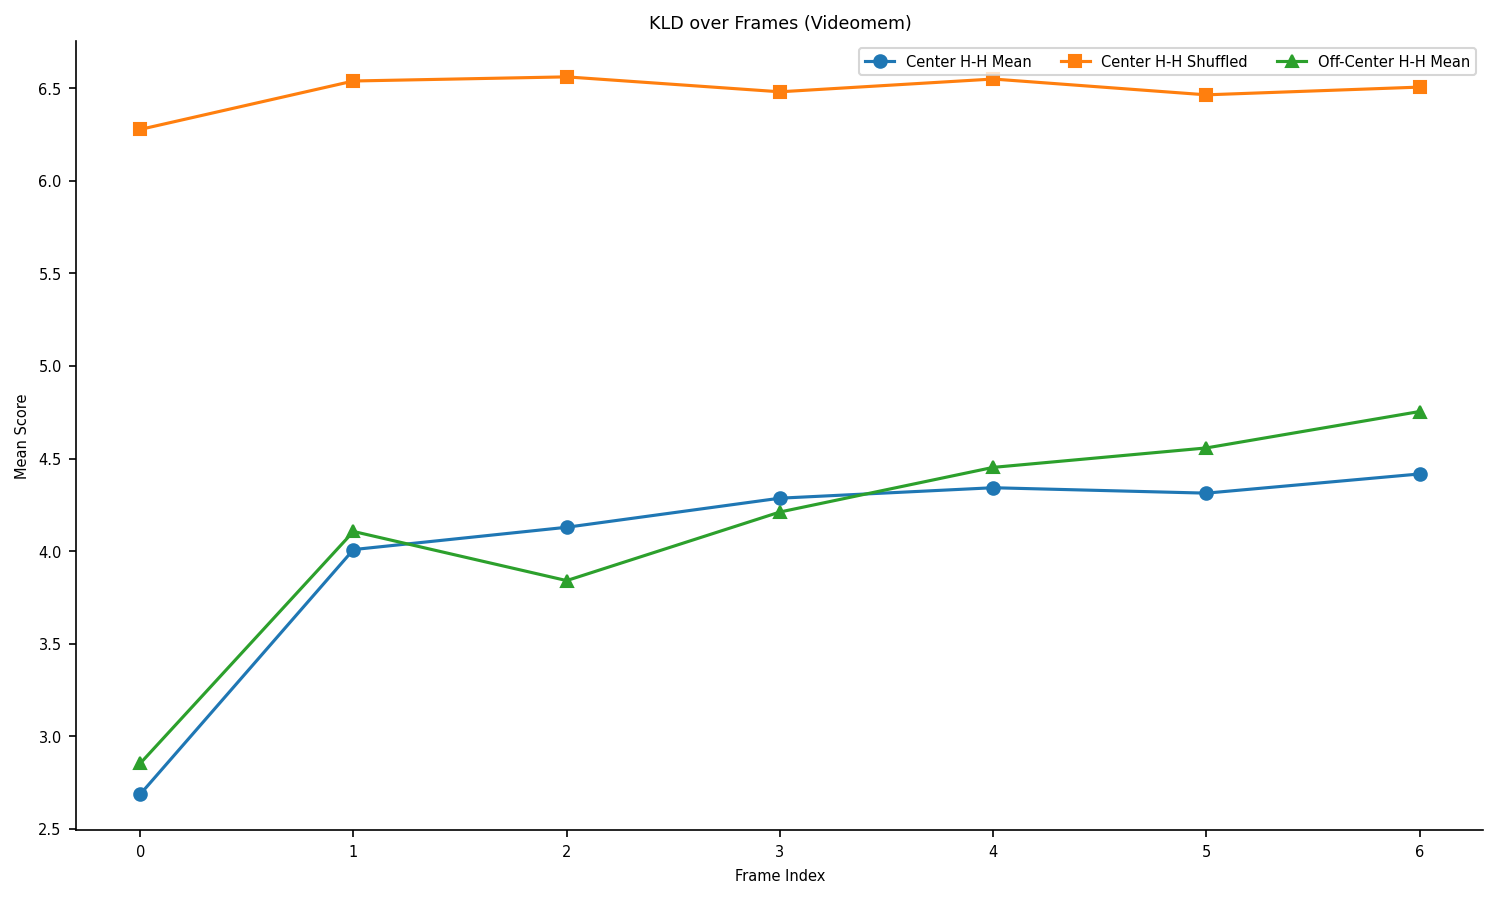

In [62]:
# Execute for current dataset
plot_frame_metrics(all_means, all_shuffled_means, noncenter_means, dataset)